In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import sys

```python

    # Load the dataset
    # Preprocess the data 
    # Perform feature scaling
    # Calculate the distance matrix from input features
    train_dist_mat = distance_matrix(data, data)

    # Initialize the unsupervised learning model
    model = KMeans(n_clusters=3)  # Specify the number of clusters
    # Fit the model to the distance matrix
    model.fit(distance_matrix)
    # Get the predicted labels for the data points
    labels = model.labels_
    # Perform further analysis or visualization with the obtained labels

    # ...

    # Evaluate the performance of the model (if applicable)
    # ...

    # Save the model (if needed)
    # ...

    pass
```

## Helper Function

In [2]:
def printStats(df, shape=True, type=True, stats=True, topFewRow=True):
    '''
    print the following statistics of the dataframes: 
    shape, type of each column, statistics of each column, top few rows.
    
    Parameters:
    df: pandas dataframe
    shape: bool, default=True
        print the shape of the dataframe
    type: bool, default=False
        print the type of each column in the dataframe
    stats: bool, default=False  
        print the statistics of each column in the dataframe
    topFewRow: bool, default=False
        print the top few rows of the dataframe
    Returns:
    None
    '''
    
    if shape:
        print("=====================================================")
        print(f"size of data is: {df.shape}")

    if type:
        print("=====================================================")
        print(f"type of each column is:\n{df.dtypes}")

    if stats:
        print("=====================================================")
        print(f"Statistics in data:\n {df.describe()}")
        
    if topFewRow:
        print("=====================================================")
        print(f"Top few rows in data:\n{df.head()}")   
        
def filter_data(df, HOUR=None, RESOURCEBID_SEQ=None):
    '''
    filter data to specific hour and and specific resourcebid_seq
    '''
    df["hr_start"] = df["SCH_BID_TIMEINTERVALSTART"].dt.hour
    df["hr_stop"] = df["SCH_BID_TIMEINTERVALSTOP"].dt.hour
    df.loc[
        df["hr_stop"] == 0,
        "hr_stop",
    ] = 24

    if RESOURCEBID_SEQ is not None:
        df = df[df["RESOURCEBID_SEQ"] == RESOURCEBID_SEQ]

    if HOUR is not None:
        df = df[
            (df["hr_start"] <= HOUR) & (df["hr_stop"] > HOUR)
        ].copy()
        
    df.sort_values(
        by=[
            "SCH_BID_TIMEINTERVALSTART",
            "SCH_BID_TIMEINTERVALSTOP",
            "SCH_BID_XAXISDATA",
        ],
        inplace=True,
    )
    return df

def extract_feat(df_data):
    '''
    extract features from the data
    '''
    matrices = {}
    grouped = df_data.groupby('SCH_BID_TIMEINTERVALSTART')

    for start_time, group in grouped:
        # For each group, select SCH_BID_XAXISDATA and SCH_BID_Y1AXISDATA and convert to a list of lists
        matrix = group[['SCH_BID_XAXISDATA', 'SCH_BID_Y1AXISDATA']].values.tolist()
        matrices[start_time] = matrix

    # print(matrices)

    # for start_time, matrix in matrices.items():
    #     print(f"Start Time: {start_time}, Matrix:\n{matrix}\n")
        
    features = {}
    for start_time, matrix in matrices.items():
        # Extract all bidding prices for the current date
        prices = [row[1] for row in matrix]
        # print(prices)
        # Calculate max, min, and range of prices
        max_price = max(prices)
        min_price = min(prices)
        avg_price = np.mean(prices)
        price_range = max_price - min_price
        # Save the features for the current date
        features[start_time] = {
            'max_price': max_price,
            'min_price': min_price,
            'avg_price': avg_price,
            'price_range': price_range,
            'num_steps': len(prices)
        }
        
    # for date, feature in features.items():
    #     print(f'Date: {date}, Features: {feature}')

    # print(f'features:\n{features}')
    df_train_feat = pd.DataFrame.from_dict(features, orient='index')
    return df_train_feat

def draw_distribution(feature):
    '''
    draw the distribution of the feature
    '''
    
    import matplotlib.pyplot as plt
    import numpy as np

    # Assuming df_train_feat is your DataFrame with the data you are plotting
    max_value = feature.max().max()  # This will get the maximum value across all columns
    bins = np.arange(-1.5, max_value + 1.5)  # +1.5 to include the rightmost edge of the last integer

    # hist is a 2D numpy array of Axes objects
    hist = feature.hist(bins=bins, figsize=(10, 8), linewidth=2, color='red')

    for axis_array in hist:
        for axis in axis_array:
            axis.set_xlabel('Quantity')
            axis.set_ylabel('Frequency')
            axis.grid(False)

    plt.tight_layout()
    plt.show()
    
def scale_feat(df):
    '''
    scale the features
    '''
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(features_scaled, index=df.index, columns=df.columns)
    return df_scaled

def plot_dist_mat(df):
    '''
    plot the distance matrix of the dataframe
    '''
    
    from sklearn.metrics import pairwise_distances
    dist_mat = pairwise_distances(df, metric='euclidean')
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Heatmap of the distance matrix
    ax = sns.heatmap(dist_mat, square=True, cmap='viridis')
    plt.title('Distance Matrix Heatmap')
    ax.set(xlabel="bid idx", ylabel="bid idx")
    ax.xaxis.tick_top()

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #rotate x-axis labels
    ax.xaxis.set_label_position('top')
    plt.show()
    

## Prepare training data 
### filter data with hour = 18, RESOURCEBID_SEQ = 100651

In [3]:
train_file = "train_combined_pub_0313_0905.csv" # train_file = "train_combined.csv"
df = pd.read_csv(train_file, low_memory=False)
df["SCH_BID_TIMEINTERVALSTART"] = pd.to_datetime(df["SCH_BID_TIMEINTERVALSTART"])
df["SCH_BID_TIMEINTERVALSTOP"] = pd.to_datetime(df["SCH_BID_TIMEINTERVALSTOP"])

printStats(df)

size of data is: (4999049, 22)
type of each column is:
STARTTIME                                object
STOPTIME                                 object
RESOURCE_TYPE                            object
SCHEDULINGCOORDINATOR_SEQ                 int64
RESOURCEBID_SEQ                           int64
TIMEINTERVALSTART                        object
TIMEINTERVALEND                          object
PRODUCTBID_DESC                         float64
PRODUCTBID_MRID                         float64
MARKETPRODUCT_DESC                      float64
MARKETPRODUCTTYPE                        object
SELFSCHEDMW                             float64
SCH_BID_TIMEINTERVALSTART        datetime64[ns]
SCH_BID_TIMEINTERVALSTOP         datetime64[ns]
SCH_BID_TIMEINTERVALSTART_GMT            object
SCH_BID_TIMEINTERVALSTOP_GMT             object
SCH_BID_XAXISDATA                       float64
SCH_BID_Y1AXISDATA                      float64
SCH_BID_Y2AXISDATA                      float64
SCH_BID_CURVETYPE                

## Preprocess the input (drop columns)

In [4]:
#drop columns
drop_columns = ['MAXEOHSTATEOFCHARGE','PRODUCTBID_DESC','PRODUCTBID_MRID', 'MARKETPRODUCT_DESC', 'SCH_BID_Y2AXISDATA', 'MINEOHSTATEOFCHARGE', 'MAXEOHSTATEOFCHARGE', 'STARTTIME', 'STOPTIME', 'RESOURCE_TYPE', 'TIMEINTERVALSTART', 'TIMEINTERVALEND', 'MARKETPRODUCTTYPE', 'SCH_BID_TIMEINTERVALSTART_GMT', 'SCH_BID_TIMEINTERVALSTOP_GMT', 'SCH_BID_CURVETYPE']
df_col_droped = df.drop(columns=drop_columns, axis='columns')

printStats(df_col_droped)

size of data is: (4999049, 7)
type of each column is:
SCHEDULINGCOORDINATOR_SEQ             int64
RESOURCEBID_SEQ                       int64
SELFSCHEDMW                         float64
SCH_BID_TIMEINTERVALSTART    datetime64[ns]
SCH_BID_TIMEINTERVALSTOP     datetime64[ns]
SCH_BID_XAXISDATA                   float64
SCH_BID_Y1AXISDATA                  float64
dtype: object
Statistics in data:
        SCHEDULINGCOORDINATOR_SEQ  RESOURCEBID_SEQ    SELFSCHEDMW  \
count               4.999049e+06     4.999049e+06  649257.000000   
mean                4.006895e+05     4.191115e+05      34.164579   
min                 1.042980e+05     1.000310e+05    -230.000000   
25%                 1.874960e+05     1.662180e+05       0.610000   
50%                 4.130870e+05     3.034200e+05       2.000000   
75%                 6.357500e+05     6.718970e+05      13.000000   
max                 9.879900e+05     9.989640e+05    1147.300000   
std                 2.352639e+05     2.916411e+05     138.5

In [5]:
HOUR = 18
RESOURCEBID_SEQ = 100651 #None
df_train = filter_data(df_col_droped, HOUR, RESOURCEBID_SEQ)

In [6]:
print(f"For resource_id {RESOURCEBID_SEQ} at hour {HOUR}:")
printStats(df_train, type=False, topFewRow=False)

from draw_bid_curve import draw_bid_curves_for_multiple_days_2d
# draw_bid_curves_for_multiple_days_2d(df_train, HOUR)

For resource_id 100651 at hour 18:
size of data is: (519, 9)
Statistics in data:
        SCHEDULINGCOORDINATOR_SEQ  RESOURCEBID_SEQ  SELFSCHEDMW  \
count                      519.0            519.0          0.0   
mean                    917730.0         100651.0          NaN   
min                     917730.0         100651.0          NaN   
25%                     917730.0         100651.0          NaN   
50%                     917730.0         100651.0          NaN   
75%                     917730.0         100651.0          NaN   
max                     917730.0         100651.0          NaN   
std                          0.0              0.0          NaN   

           SCH_BID_TIMEINTERVALSTART       SCH_BID_TIMEINTERVALSTOP  \
count                            519                            519   
mean   2023-06-08 18:47:16.994219520  2023-06-09 13:01:09.364161792   
min              2023-03-13 00:00:00            2023-03-14 00:00:00   
25%              2023-04-25 00:00:00   

## Create feature matrix


$$
feature\ i:\ x_i = 


\begin{bmatrix}
max\_price \\
min\_price \\
avg\_price \\
price\_range \\
num\_steps
\end{bmatrix}
$$

In [7]:
df_train_feat = extract_feat(df_train)
print("\nStatistics before scaling:")
printStats(df_train_feat, type=False)



Statistics before scaling:
size of data is: (174, 5)
Statistics in data:
          max_price    min_price    avg_price  price_range   num_steps
count   174.000000   174.000000   174.000000   174.000000  174.000000
mean    955.373563   710.395632   871.313391   244.977931    2.982759
std     192.015725   435.098595   224.883847   414.681830    0.273579
min      77.000000    -5.000000    77.000000     0.000000    2.000000
25%    1000.000000   100.000000   692.083333     0.010000    3.000000
50%    1000.000000   999.990000   999.996667     0.010000    3.000000
75%    1000.000000   999.990000   999.996667   506.250000    3.000000
max    1000.000000  1000.000000  1000.000000  1005.000000    4.000000
Top few rows in data:
            max_price  min_price   avg_price  price_range  num_steps
2023-03-13     1000.0     999.99  999.996667         0.01          3
2023-03-14     1000.0     999.99  999.996667         0.01          3
2023-03-15     1000.0     999.99  999.996667         0.01         

## Feature scaling

$$
z_i = \frac{x_i - \mu}{\sigma}
$$


where 
 *  $z_i$ is the scaled value,
 *  $x_i$ is the original value,
 *  ${\mu}$ is the mean of the feature,
 *  ${\sigma}$ is the standard deviation of the feature $X$.

In [8]:
df_train_feat_scaled = scale_feat(df_train_feat)
print("\nStatistics after scaling:")
printStats(df_train_feat_scaled, type=False)


Statistics after scaling:
size of data is: (174, 5)
Statistics in data:
           max_price     min_price     avg_price   price_range     num_steps
count  1.740000e+02  1.740000e+02  1.740000e+02  1.740000e+02  1.740000e+02
mean  -6.125368e-17  1.633432e-16 -7.350442e-16 -2.450147e-16 -2.603282e-16
std    1.002886e+00  1.002886e+00  1.002886e+00  1.002886e+00  1.002886e+00
min   -4.587690e+00 -1.648960e+00 -3.542299e+00 -5.924661e-01 -3.602596e+00
25%    2.330811e-01 -1.406939e+00 -7.992896e-01 -5.924419e-01  6.320343e-02
50%    2.330811e-01  6.675042e-01  5.738725e-01 -5.924419e-01  6.320343e-02
75%    2.330811e-01  6.675042e-01  5.738725e-01  6.318726e-01  6.320343e-02
max    2.330811e-01  6.675272e-01  5.738874e-01  1.838073e+00  3.729002e+00
Top few rows in data:
            max_price  min_price  avg_price  price_range  num_steps
2023-03-13   0.233081   0.667504   0.573873    -0.592442   0.063203
2023-03-14   0.233081   0.667504   0.573873    -0.592442   0.063203
2023-03-15   0.2

## Distribution

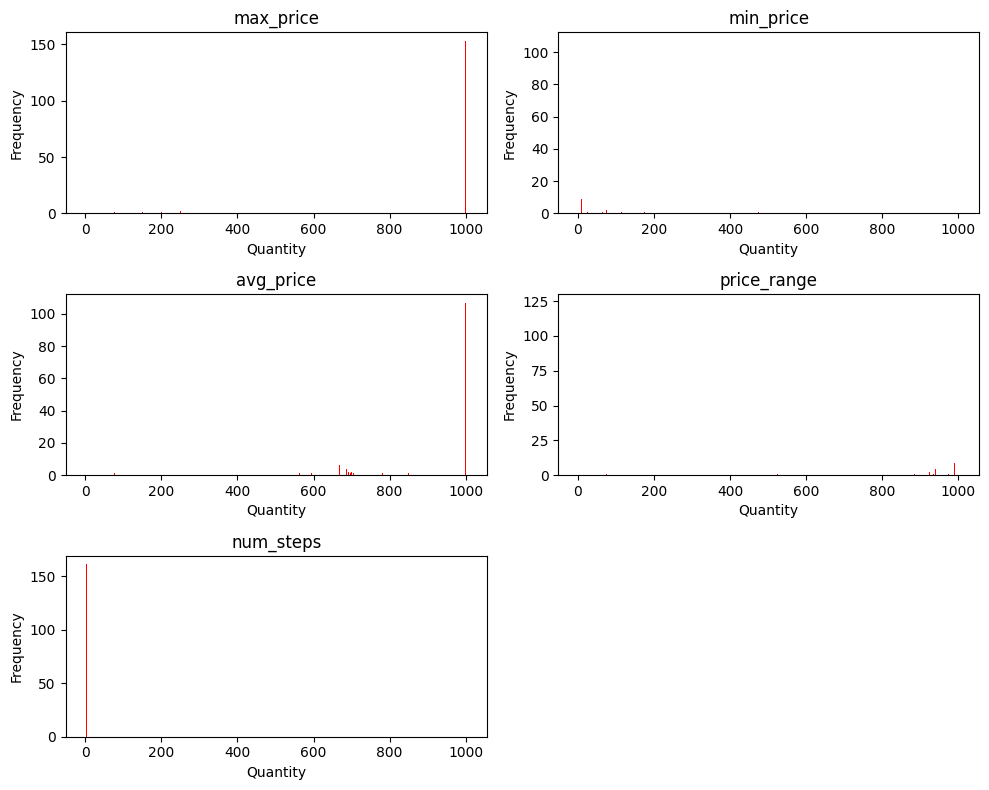

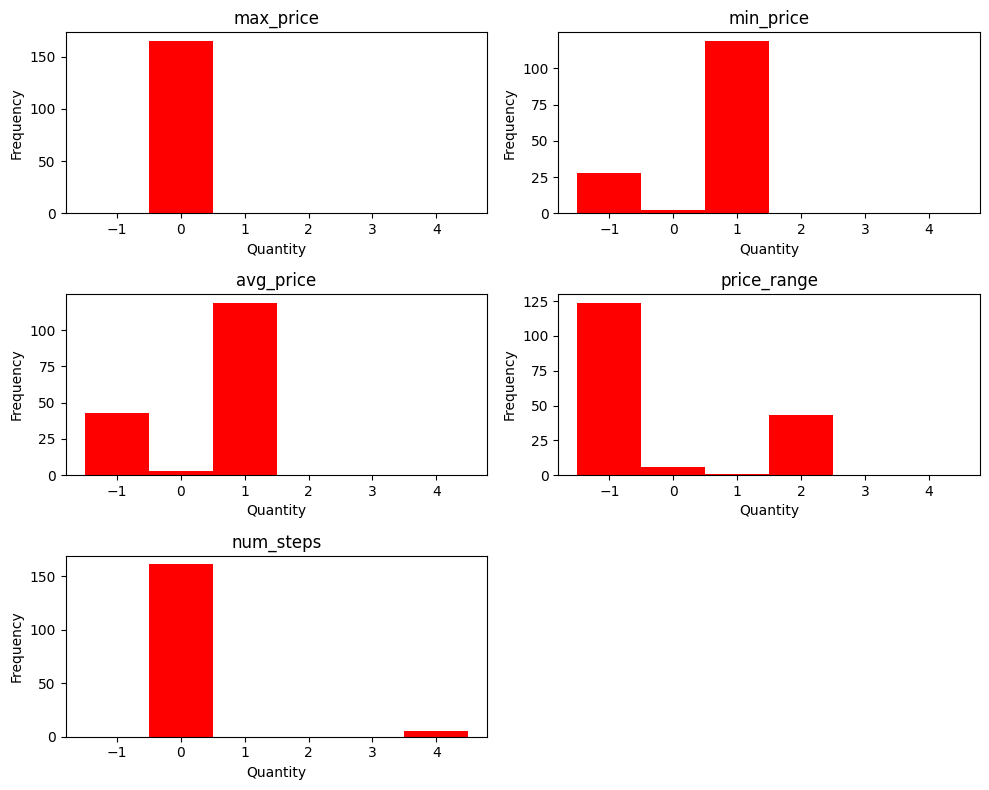

In [9]:
draw_distribution(df_train_feat)
draw_distribution(df_train_feat_scaled)


## PCA analysis (reduce dimension)

In [10]:
df_train_feat_scaled

,max_price,min_price,avg_price,price_range,num_steps
2023-03-13,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-14,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-15,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-16,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-17,0.233081,0.667504,0.573873,-0.592442,0.063203
...,...,...,...,...,...
2023-09-01,0.227858,0.665199,0.569413,-0.592442,0.063203
2023-09-02,0.227858,0.665199,0.569413,-0.592442,0.063203
2023-09-03,0.227858,0.665199,0.569413,-0.592442,0.063203
2023-09-04,0.227858,0.665199,0.569413,-0.592442,0.063203


[5.51546854e-01 3.35816898e-01 1.12194464e-01 4.41783834e-04
 1.23018961e-32]


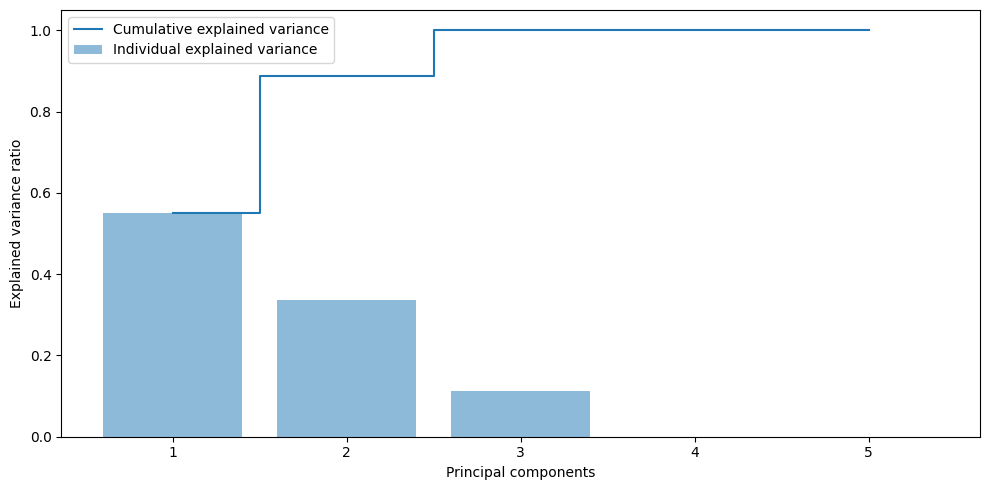

In [11]:
from sklearn.decomposition import PCA

# Assuming df_train_feat_scaled is your scaled feature DataFrame
pca = PCA()
pca.fit(df_train_feat_scaled)

explained_variance = pca.explained_variance_ratio_
print(explained_variance)

# Plotting the scree plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance)+1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance)+1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


From the figure, we see that 
- 1st PC (Principle Component) represents over half of the variability in your data.
- 2nd PC accounts for roughly 34.7% of the variance.

Together with the first component, these two capture about 89.6% of the total variance.
- 3rd PC: adds another 10.4% to the variance explained

totaling around 100% when combined with the first 3 components.

=> Select component=3

In [12]:
df_train_feat_scaled

,max_price,min_price,avg_price,price_range,num_steps
2023-03-13,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-14,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-15,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-16,0.233081,0.667504,0.573873,-0.592442,0.063203
2023-03-17,0.233081,0.667504,0.573873,-0.592442,0.063203
...,...,...,...,...,...
2023-09-01,0.227858,0.665199,0.569413,-0.592442,0.063203
2023-09-02,0.227858,0.665199,0.569413,-0.592442,0.063203
2023-09-03,0.227858,0.665199,0.569413,-0.592442,0.063203
2023-09-04,0.227858,0.665199,0.569413,-0.592442,0.063203


In [32]:
pca = PCA(n_components=3)

# fit PCA on the scaled data
pca.fit(df_train_feat_scaled)

# transform the scaled data to principal components
X_pca = pca.transform(df_train_feat_scaled)
print("Original shape: ", df_train_feat_scaled.shape)
print("Transformed shape: ", X_pca.shape)

Original shape:  (174, 4)
Transformed shape:  (174, 3)


In [33]:
# 3D scatter plot
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=df_train_feat_scaled['PC1'],
    y=df_train_feat_scaled['PC2'],
    z=df_train_feat_scaled['PC3'],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8
    ),
)])

# Set plot layout
fig.update_layout(
    title='3D Scatter Plot of PCA Components',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the plot
fig.show()

In [14]:
df_pca = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2', 'PC3'], index=df_train_feat_scaled.index)
# printStats(df_pca)
df_pca

,PC1,PC2,PC3
2023-03-13,-1.059196,0.240490,0.066822
2023-03-14,-1.059196,0.240490,0.066822
2023-03-15,-1.059196,0.240490,0.066822
2023-03-16,-1.059196,0.240490,0.066822
2023-03-17,-1.059196,0.240490,0.066822
...,...,...,...
2023-09-01,-1.053336,0.243314,0.070008
2023-09-02,-1.053336,0.243314,0.070008
2023-09-03,-1.053336,0.243314,0.070008
2023-09-04,-1.053336,0.243314,0.070008


## Visualization of distance matrix for scaled features

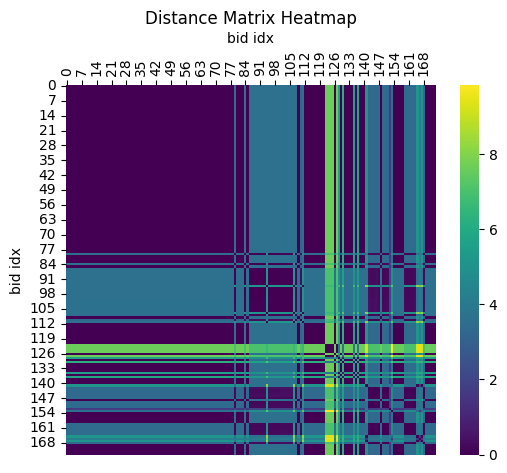

In [15]:
plot_dist_mat(df_pca)

In [16]:
df_train_feat_scaled = df_pca

## Clustering

In [17]:
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from sklearn.metrics import pairwise_distances

intra_cluster_error = []
inter_cluster_error = []

min_clusters = 2
max_clusters = 20
for n_clusters in range(min_clusters, max_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_train_feat_scaled)
    intra_cluster_error.append(kmeans.inertia_)# the sum of squared distances of samples to their closest cluster center

    centroid = kmeans.cluster_centers_
    pairwise_dists = pairwise_distances(centroid)
    squared_pairwise_dists = pairwise_dists**2
    sum_squared_distances = np.sum(np.triu(squared_pairwise_dists, 1)) # sum the upper triangle part excluding the diagonal
    inter_cluster_error.append(sum_squared_distances)
    
    
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(min_clusters, max_clusters)), y=intra_cluster_error, mode='lines+markers', name='Intra-cluster error (Sum of Squared Distances)'))
fig.add_trace(go.Scatter(x=list(range(min_clusters, max_clusters)), y=inter_cluster_error, mode='lines+markers', name='Inter-cluster error (Sum of Squared Distances Between Centroids)'))

fig.update_layout(
    title='Error vs Number of Clusters',
    xaxis_title='Number of Clusters',
    yaxis_title='Error',
    hovermode='x'  # enable hover feature
)

fig.show()




## Choose cluster number = 3 (elbow)
<div style="text-align: center;">
    <img src="./img/k_selection.jpg" width="50%" />
</div>

In [18]:
print(f"num of points: {len(df_train_feat_scaled)}")

n_clusters = 3

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_train_feat_scaled)
centroid = kmeans.cluster_centers_

# assign the cluster labels to each bid
df_train_feat_scaled['cluster_label'] = kmeans.labels_
df_train_feat_scaled.head()

num of points: 174


,PC1,PC2,PC3,cluster_label
2023-03-13,-1.059196,0.24049,0.066822,1
2023-03-14,-1.059196,0.24049,0.066822,1
2023-03-15,-1.059196,0.24049,0.066822,1
2023-03-16,-1.059196,0.24049,0.066822,1
2023-03-17,-1.059196,0.24049,0.066822,1


In [19]:
cluster_labels = df_train_feat_scaled[['cluster_label']].copy()
cluster_labels.head()

,cluster_label
2023-03-13,1
2023-03-14,1
2023-03-15,1
2023-03-16,1
2023-03-17,1


# plot 3d clustering in space

In [34]:
# 3D scatter plot
import plotly.express as px 

fig = go.Figure()

labels = df_train_feat_scaled['cluster_label'].unique()
colors = px.colors.qualitative.Plotly

for i, label in enumerate(labels):
    # filter row with current label
    df_label = df_train_feat_scaled[df_train_feat_scaled['cluster_label'] == label]
    
    fig.add_trace(go.Scatter3d(
        x=df_label['PC1'],
        y=df_label['PC2'],
        z=df_label['PC3'],
        mode='markers',
        marker=dict(
            size=5,
            color=colors[i% len(colors)],
            opacity=0.8
        ),
        name=f'Cluster {label}'
    ))

fig.update_layout(
    title='3D Scatter Plot of PCA Components',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        camera=dict(
            eye=dict(x=2, y=-1.5, z=1) 
        )
    ),
    legend_title_text='Cluster Labels', 
    margin=dict(l=0, r=0, b=0, t=30)
)

# Show the plot
fig.show()


## Show clustering results

In [21]:
from draw_bid_curve import draw_bid_curves_for_multiple_days_2d
draw_bid_curves_for_multiple_days_2d(df_train, HOUR, cluster_labels)

# Check if there is difference in clustering w & w/o using PCA (Remains to be finished...)

## Testing

In [22]:
valid_file = "valid_combined_pub_0906_1023.csv"
df_valid_raw = pd.read_csv(valid_file, low_memory=False)
df_valid_raw["SCH_BID_TIMEINTERVALSTART"] = pd.to_datetime(df_valid_raw["SCH_BID_TIMEINTERVALSTART"])
df_valid_raw["SCH_BID_TIMEINTERVALSTOP"] = pd.to_datetime(df_valid_raw["SCH_BID_TIMEINTERVALSTOP"])

printStats(df_valid_raw)

size of data is: (1244549, 22)
type of each column is:
STARTTIME                                object
STOPTIME                                 object
RESOURCE_TYPE                            object
SCHEDULINGCOORDINATOR_SEQ                 int64
RESOURCEBID_SEQ                           int64
TIMEINTERVALSTART                        object
TIMEINTERVALEND                          object
PRODUCTBID_DESC                         float64
PRODUCTBID_MRID                         float64
MARKETPRODUCT_DESC                      float64
MARKETPRODUCTTYPE                        object
SELFSCHEDMW                             float64
SCH_BID_TIMEINTERVALSTART        datetime64[ns]
SCH_BID_TIMEINTERVALSTOP         datetime64[ns]
SCH_BID_TIMEINTERVALSTART_GMT            object
SCH_BID_TIMEINTERVALSTOP_GMT             object
SCH_BID_XAXISDATA                       float64
SCH_BID_Y1AXISDATA                      float64
SCH_BID_Y2AXISDATA                      float64
SCH_BID_CURVETYPE                

### drop columns

In [23]:
df_valid_raw_col_droped = df_valid_raw.drop(columns=drop_columns, axis='columns')

printStats(df_valid_raw_col_droped)

size of data is: (1244549, 7)
type of each column is:
SCHEDULINGCOORDINATOR_SEQ             int64
RESOURCEBID_SEQ                       int64
SELFSCHEDMW                         float64
SCH_BID_TIMEINTERVALSTART    datetime64[ns]
SCH_BID_TIMEINTERVALSTOP     datetime64[ns]
SCH_BID_XAXISDATA                   float64
SCH_BID_Y1AXISDATA                  float64
dtype: object
Statistics in data:
        SCHEDULINGCOORDINATOR_SEQ  RESOURCEBID_SEQ    SELFSCHEDMW  \
count               1.244549e+06     1.244549e+06  159726.000000   
mean                4.050901e+05     4.276710e+05      29.673578   
min                 1.042980e+05     1.002320e+05    -230.000000   
25%                 1.874960e+05     1.666000e+05       0.570000   
50%                 4.174540e+05     3.271420e+05       1.800000   
75%                 6.212000e+05     6.935430e+05      12.200000   
max                 9.879900e+05     9.989640e+05    1150.000000   
std                 2.347220e+05     2.913479e+05     121.4

In [24]:
df_valid = filter_data(df_valid_raw_col_droped, HOUR, RESOURCEBID_SEQ)
printStats(df_valid)

size of data is: (130, 9)
type of each column is:
SCHEDULINGCOORDINATOR_SEQ             int64
RESOURCEBID_SEQ                       int64
SELFSCHEDMW                         float64
SCH_BID_TIMEINTERVALSTART    datetime64[ns]
SCH_BID_TIMEINTERVALSTOP     datetime64[ns]
SCH_BID_XAXISDATA                   float64
SCH_BID_Y1AXISDATA                  float64
hr_start                            float64
hr_stop                             float64
dtype: object
Statistics in data:
        SCHEDULINGCOORDINATOR_SEQ  RESOURCEBID_SEQ  SELFSCHEDMW  \
count                      130.0            130.0          0.0   
mean                    917730.0         100651.0          NaN   
min                     917730.0         100651.0          NaN   
25%                     917730.0         100651.0          NaN   
50%                     917730.0         100651.0          NaN   
75%                     917730.0         100651.0          NaN   
max                     917730.0         100651.0        

In [25]:
print(f"For resource_id {RESOURCEBID_SEQ} at hour {HOUR}:")
printStats(df_valid, type=False, topFewRow=False)

from draw_bid_curve import draw_bid_curves_for_multiple_days_2d
draw_bid_curves_for_multiple_days_2d(df_valid, HOUR)

For resource_id 100651 at hour 18:
size of data is: (130, 9)
Statistics in data:
        SCHEDULINGCOORDINATOR_SEQ  RESOURCEBID_SEQ  SELFSCHEDMW  \
count                      130.0            130.0          0.0   
mean                    917730.0         100651.0          NaN   
min                     917730.0         100651.0          NaN   
25%                     917730.0         100651.0          NaN   
50%                     917730.0         100651.0          NaN   
75%                     917730.0         100651.0          NaN   
max                     917730.0         100651.0          NaN   
std                          0.0              0.0          NaN   

           SCH_BID_TIMEINTERVALSTART       SCH_BID_TIMEINTERVALSTOP  \
count                            130                            130   
mean   2023-09-30 09:20:46.153846272  2023-09-30 18:10:36.923076864   
min              2023-09-06 00:00:00            2023-09-07 00:00:00   
25%              2023-09-18 10:30:00   

In [26]:
df_valid_feat = extract_feat(df_valid)
print("\nStatistics before scaling:")
printStats(df_valid_feat, type=False)



Statistics before scaling:
size of data is: (44, 5)
Statistics in data:
          max_price   min_price   avg_price  price_range  num_steps
count    44.000000   44.000000   44.000000    44.000000  44.000000
mean    958.772727  371.769545  763.105000   587.003182   2.954545
std     189.566686  434.419530  204.708789   449.790485   0.210707
min     100.000000   40.000000  100.000000     0.000000   2.000000
25%     999.000000   60.000000  686.666667     0.010000   3.000000
50%    1000.000000  100.000000  695.000000   900.000000   3.000000
75%    1000.000000  998.990000  998.996667   940.000000   3.000000
max    1000.000000  998.990000  998.996667   960.000000   3.000000
Top few rows in data:
                     max_price  min_price   avg_price  price_range  num_steps
2023-09-06 00:00:00      999.0     998.99  998.996667         0.01          3
2023-09-07 18:00:00     1000.0      60.00  686.666667       940.00          3
2023-09-10 00:00:00      999.0     998.99  998.996667         0.01 

In [27]:
df_valid_feat_scaled = scale_feat(df_valid_feat)

print("\nStatistics after scaling:")
printStats(df_valid_feat_scaled, type=False)


Statistics after scaling:
size of data is: (44, 5)
Statistics in data:
           max_price     min_price     avg_price   price_range     num_steps
count  4.400000e+01  4.400000e+01  4.400000e+01  4.400000e+01  4.400000e+01
mean   8.452834e-17 -1.690567e-16  2.296143e-16 -2.270911e-17 -1.778880e-16
std    1.011561e+00  1.011561e+00  1.011561e+00  1.011561e+00  1.011561e+00
min   -4.582562e+00 -7.725370e-01 -3.276709e+00 -1.320147e+00 -4.582576e+00
25%    2.146598e-01 -7.259663e-01 -3.777173e-01 -1.320125e+00  2.182179e-01
50%    2.199960e-01 -6.328249e-01 -3.365384e-01  7.039175e-01  2.182179e-01
75%    2.199960e-01  1.460505e+00  1.165650e+00  7.938759e-01  2.182179e-01
max    2.199960e-01  1.460505e+00  1.165650e+00  8.388551e-01  2.182179e-01
Top few rows in data:
                     max_price  min_price  avg_price  price_range  num_steps
2023-09-06 00:00:00   0.214660   1.460505   1.165650    -1.320125   0.218218
2023-09-07 18:00:00   0.219996  -0.725966  -0.377717     0.793876  

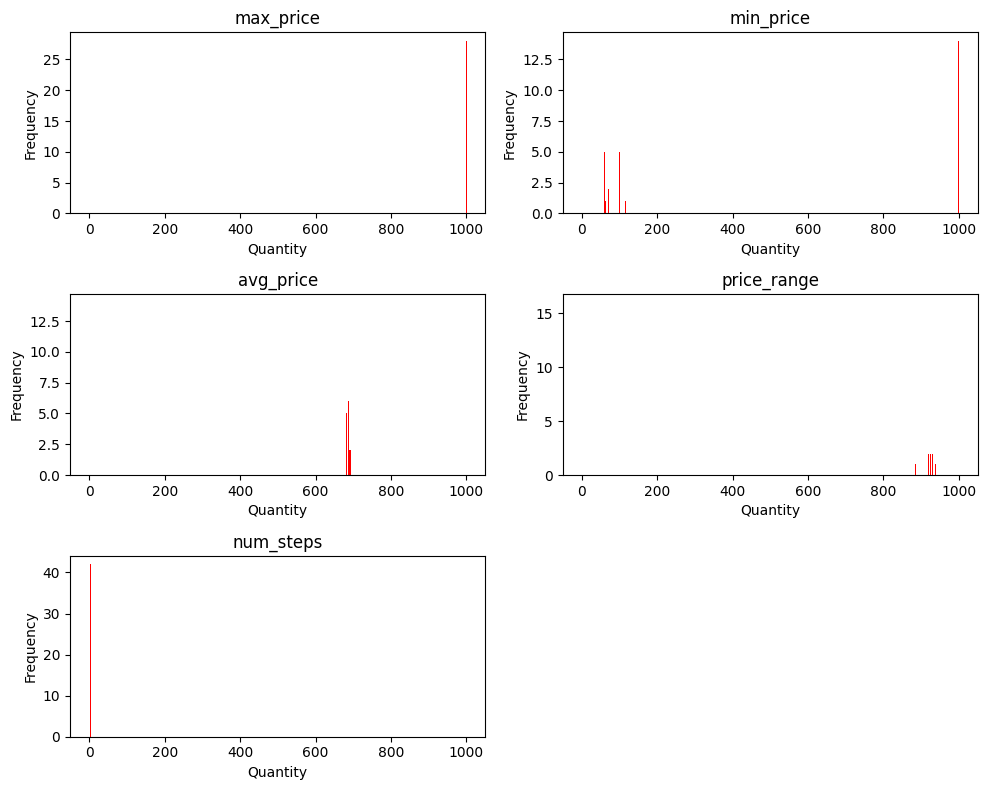

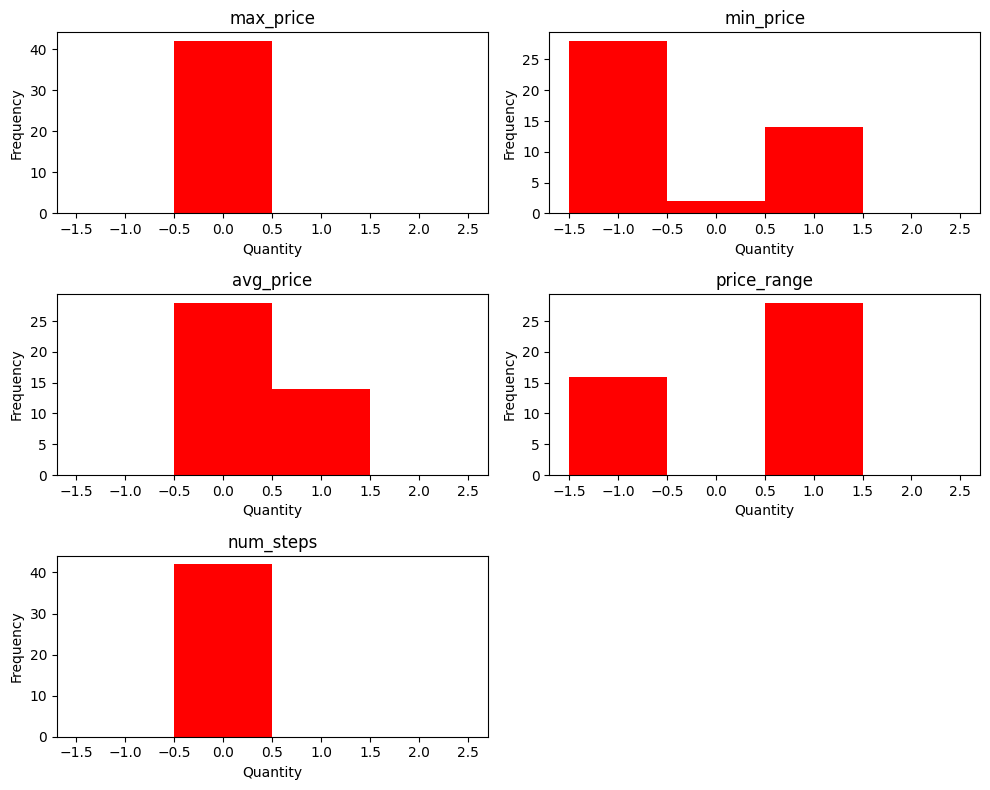

In [28]:
draw_distribution(df_valid_feat)
draw_distribution(df_valid_feat_scaled)

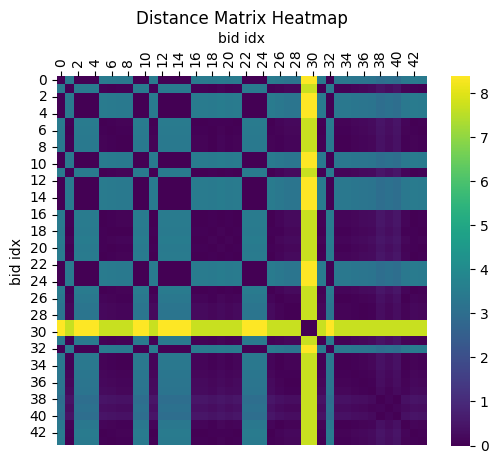

In [29]:
plot_dist_mat(df_valid_feat_scaled)

## Hypothesis Testing
check which cluster each bidding belongs to

In [30]:
validation_labels = kmeans.predict(df_valid_feat_scaled)
df_valid_feat_scaled['cluster_label'] = validation_labels

cluster_labels_valid = df_valid_feat_scaled[['cluster_label']].copy()

from draw_bid_curve import draw_bid_curves_for_multiple_days_2d
draw_bid_curves_for_multiple_days_2d(df_valid, HOUR, cluster_labels_valid)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- avg_price
- max_price
- min_price
- num_steps
- price_range
Feature names seen at fit time, yet now missing:
- PC1
- PC2
- PC3
